In [79]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from mpl_toolkits.mplot3d import Axes3D
from utils import display_image, display_images, matplotlib_show_images

In [189]:
blue = np.uint8([[[255,0,0]]])
hsv_blue = cv.cvtColor(blue, cv.COLOR_BGR2HSV)
print(hsv_blue)

green = np.uint8([[[0,255,0]]])
hsv_green = cv.cvtColor(green, cv.COLOR_BGR2HSV)
print(hsv_green)

red = np.uint8([[[0,0,255]]])
hsv_red = cv.cvtColor(red, cv.COLOR_BGR2HSV)
print(hsv_red)

[[[120 255 255]]]
[[[ 60 255 255]]]
[[[  0 255 255]]]


In [208]:
img = cv.imread("w8/images/w8/apples/apple1.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

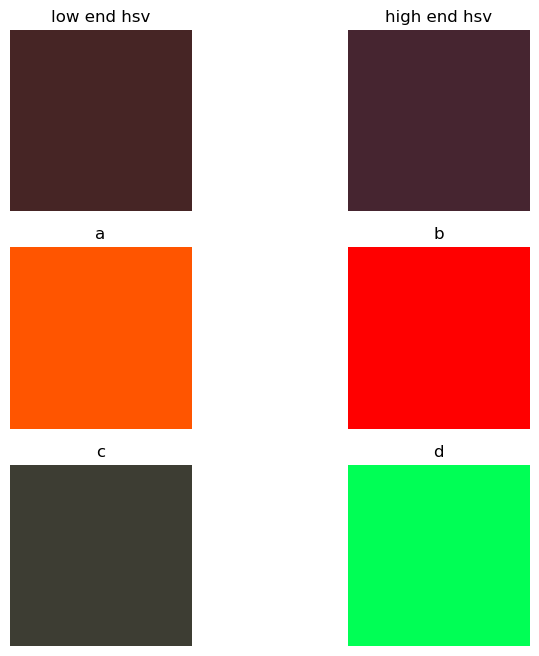

In [240]:
red_low = (0, 120, 70)
red_high1 =(10, 255, 255)
red_low2 = (170, 120, 70)
red_high2 = (180, 255, 255)
green_low = (30, 40, 61)
green_high = (70, 255, 255)

# debugging code
red_low_patch = np.full((10, 10, 3), red_low, dtype=np.uint8)
red_low2_patch = np.full((10, 10, 3), red_low2, dtype=np.uint8)
red_high1_patch = np.full((10, 10, 3), red_high1, dtype=np.uint8)
red_high2_patch = np.full((10, 10, 3), red_high2, dtype=np.uint8)
green_low_patch = np.full((10, 10, 3), green_low, dtype=np.uint8)
green_high_patch = np.full((10, 10, 3), green_high, dtype=np.uint8)

# HSV > RGB
red_low_rgb = cv.cvtColor(red_low_patch, cv.COLOR_HSV2RGB)
red_low2_rgb = cv.cvtColor(red_low2_patch, cv.COLOR_HSV2RGB)
red_high1_rgb = cv.cvtColor(red_high1_patch, cv.COLOR_HSV2RGB)
red_high2_rgb = cv.cvtColor(red_high2_patch, cv.COLOR_HSV2RGB)
green_low_rgb = cv.cvtColor(green_low_patch, cv.COLOR_HSV2RGB)
green_high_rgb = cv.cvtColor(green_high_patch, cv.COLOR_HSV2RGB)

matplotlib_show_images([red_low_rgb, red_low2_rgb, red_high1_rgb, red_high2_rgb, green_low_rgb, green_high_rgb], 3, 2, titles=("low end hsv", "high end hsv", "a", "b","c", "d"), figsize=(8,8))

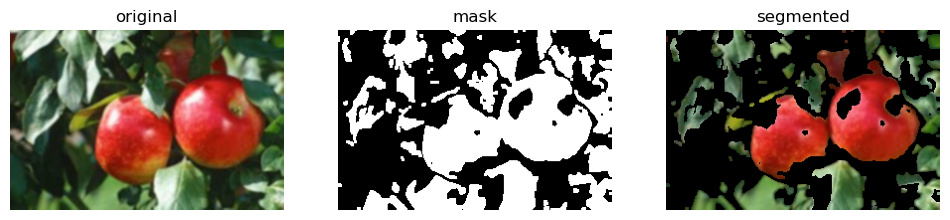

uint8
(182, 276)


In [241]:
mask = cv.inRange(img_hsv, red_low, red_high1)
mask2 = cv.inRange(img_hsv, red_low2, red_high2)
mask3 = cv.inRange(img_hsv, green_low, green_high)
red_mask = cv.bitwise_or(mask, mask2)
all_mask = cv.bitwise_or(red_mask, mask3)
all_mask = cv.morphologyEx(all_mask, cv.MORPH_OPEN, None)
segmented = cv.bitwise_and(img, img, mask=all_mask)

num_red_apples = len(np.unique(red_mask))
num_green_apples = len(np.unique(mask3))

matplotlib_show_images([img, all_mask, segmented], 1, 3, titles=("original", "mask", "segmented"), figsize=(12, 4))

print(all_mask.dtype)
print(all_mask.shape)

In [287]:
imgs = []
masks = []
res = []

def detect_contours(mask):
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours

for i in range(1, 6):
    img = cv.imread(f"w8/images/w8/apples/apple{i}.jpg")
    img = cv.GaussianBlur(img, (5, 5), 0)
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    mask = cv.inRange(img_hsv, red_low, red_high1)
    mask2 = cv.inRange(img_hsv, red_low2, red_high2)
    green_mask = cv.inRange(img_hsv, green_low, green_high)
    
    red_mask = cv.bitwise_or(mask, mask2)
    all_mask = cv.bitwise_or(red_mask, green_mask)

    kernel = np.ones((5, 5), np.uint8)
    all_mask = cv.morphologyEx(all_mask, cv.MORPH_OPEN, kernel)
    all_mask = cv.morphologyEx(all_mask, cv.MORPH_CLOSE, kernel)

    segmented_img = cv.bitwise_and(img, img, mask=all_mask)

    height, width, _ = segmented_img.shape
    text_y_position = height - 50  

    red_contours = detect_contours(red_mask)
    green_contours = detect_contours(green_mask)
    
    min_contour_area = 3125  
    red_contours = [cnt for cnt in red_contours if cv.contourArea(cnt) > min_contour_area]
    green_contours = [cnt for cnt in green_contours if cv.contourArea(cnt) > min_contour_area]
    
    cv.drawContours(segmented_img, red_contours, -1, (255, 0, 0), 3)
    cv.drawContours(segmented_img, green_contours, -1, (0, 255, 0), 3)
    
    num_red_apples = len(red_contours)
    num_green_apples = len(green_contours)

    cv.putText(segmented_img, f'# red apples: {num_red_apples}', (10, text_y_position),
                cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv.LINE_AA)  
    cv.putText(segmented_img, f'# green apples: {num_green_apples}', (10, text_y_position + 30),
                cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv.LINE_AA)  

    imgs.append(img)
    res.append(segmented_img)

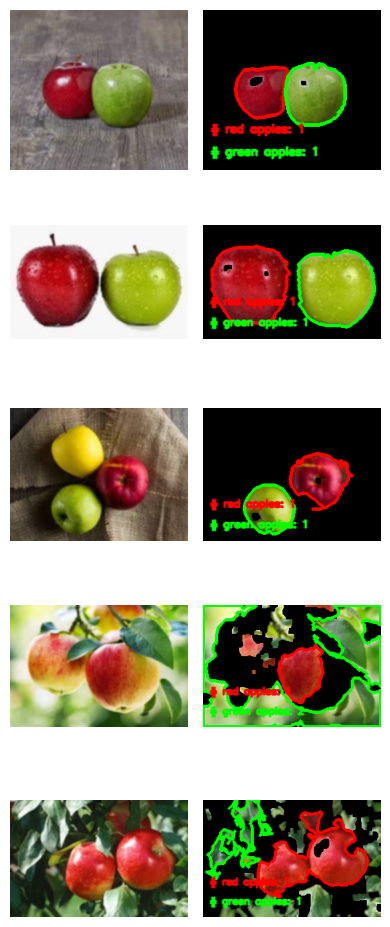

In [288]:
fig, ax = plt.subplots(5, 2, figsize=(4, 10))

for i, (img, segmented) in enumerate(zip(imgs, res)):
    ax[i][0].imshow(img)
    ax[i][0].axis("off")
    ax[i][1].imshow(segmented)
    ax[i][1].axis("off")
    height, width= segmented[i].shape
    text_y_position = height - 100
    cv.putText(segmented[i], f'# red apples: {num_red_apples}', (10, text_y_position),
            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv.LINE_AA)  # Reduced font scale to 0.7
    cv.putText(segmented[i], f'# green apples: {num_green_apples}', (10, text_y_position + 30),
            cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv.LINE_AA)  # Reduced font scale to 0.7

plt.tight_layout()
plt.show()

In [25]:

apple = cv2.imread("images/w8/apples/apple1.jpg")

apple_hsv = cv2.cvtColor(apple, cv2.COLOR_BGR2HSV)

# Define color range for red (two ranges due to the circular nature of HSV)
lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

# Define color range for green
lower_green = np.array([36, 50, 70])
upper_green = np.array([89, 255, 255])

# Create masks for red and green
mask_red1 = cv2.inRange(apple_hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(apple_hsv, lower_red2, upper_red2)
mask_red = cv2.add(mask_red1, mask_red2)  # Combine the two red masks
mask_green = cv2.inRange(apple_hsv, lower_green, upper_green)

# Segment the apples
red_apples = cv2.bitwise_and(apple, apple, mask=mask_red)
green_apples = cv2.bitwise_and(apple, apple, mask=mask_green)

# Combine the results for display
segmented_image = cv2.addWeighted(red_apples, 1, green_apples, 1, 0)

# Calculate the position for the text to appear below the apples
height, width, _ = segmented_image.shape
text_y_position = height - 50  # Adjust the position from the bottom

# Add text to display the count of apples
num_red_apples = len(np.unique(mask_red)) - 1  # Subtracting 1 to remove background
num_green_apples = len(np.unique(mask_green)) - 1  # Subtracting 1 to remove background

cv2.putText(segmented_image, f'# red apples: {num_red_apples}', (10, text_y_position),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)  # Reduced font scale to 0.7
cv2.putText(segmented_image, f'# green apples: {num_green_apples}', (10, text_y_position + 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)  # Reduced font scale to 0.7

# Display the result
cv2.imshow('Segmented Apples', segmented_image)
cv2.waitKey(0)
cv.destroyAllWindows()

NameError: name 'cv2' is not defined

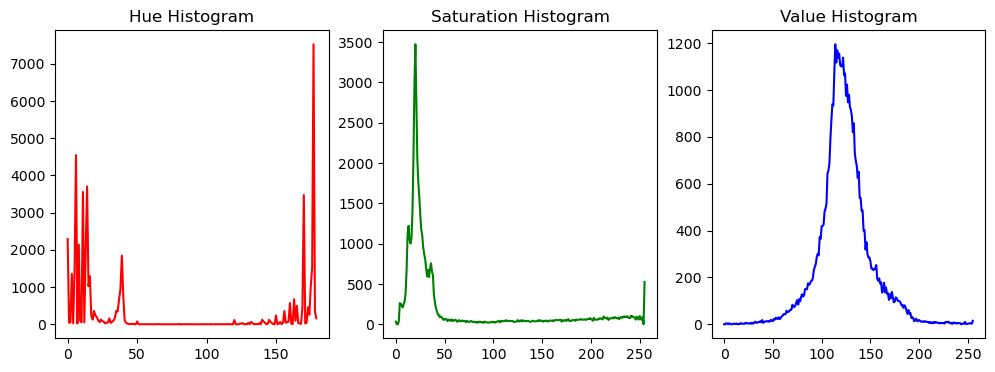

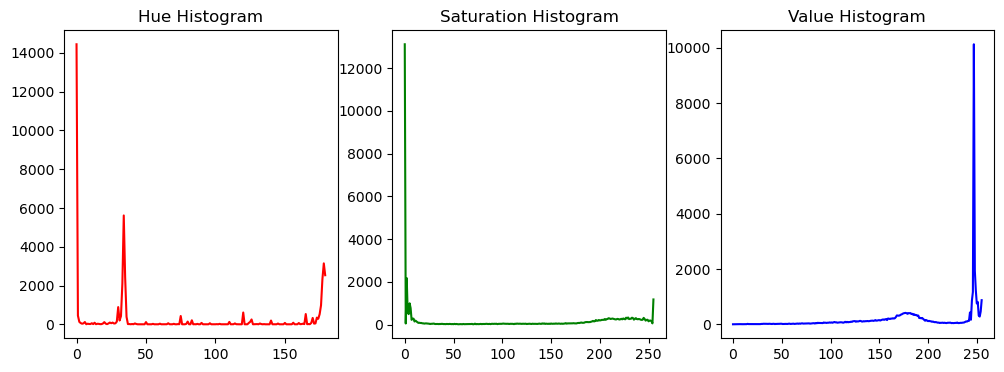

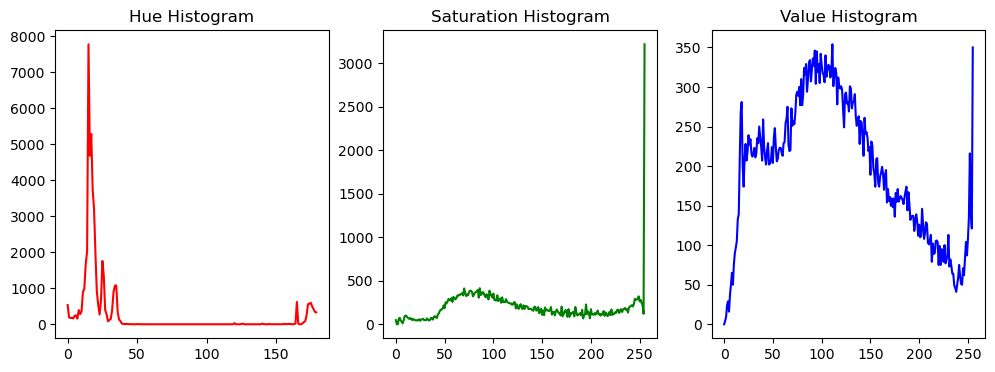

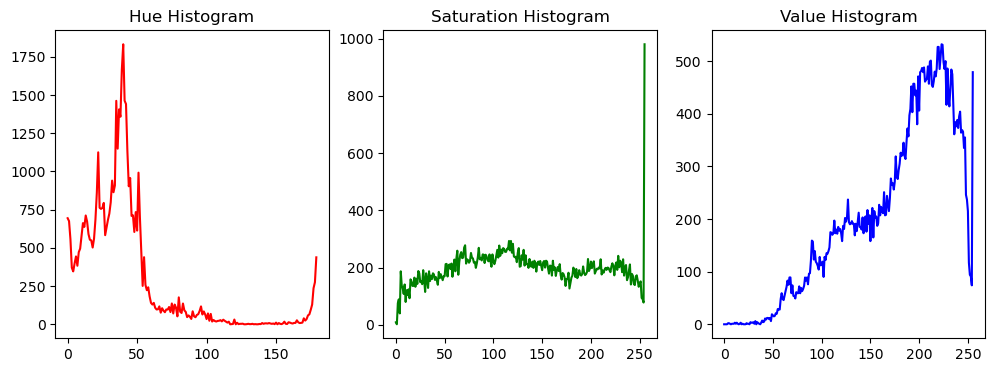

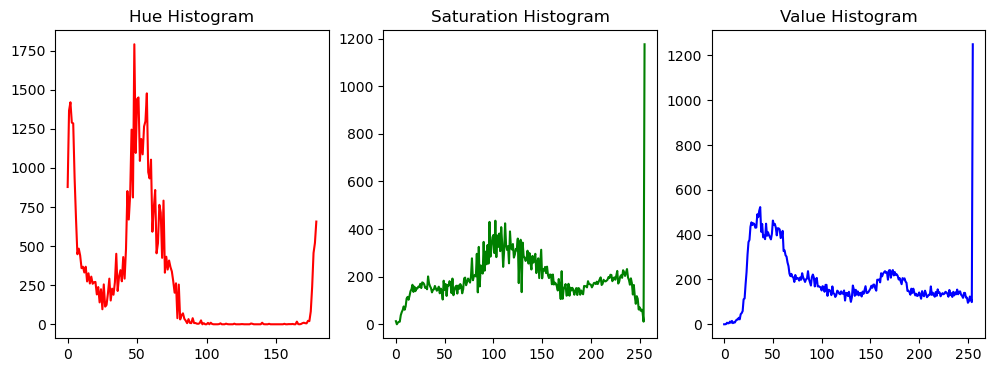

In [145]:
# Load the image and convert it to HSV
for i in range(1, 6):
    img = cv.imread(f"w8/images/w8/apples/apple{i}.jpg")
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Calculate histograms for each channel
    h_hist = cv.calcHist([img_hsv], [0], None, [180], [0, 180])
    s_hist = cv.calcHist([img_hsv], [1], None, [256], [0, 256])
    v_hist = cv.calcHist([img_hsv], [2], None, [256], [0, 256])

# Plot the histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(h_hist, color='r')
    plt.title('Hue Histogram')
    plt.subplot(1, 3, 2)
    plt.plot(s_hist, color='g')
    plt.title('Saturation Histogram')
    plt.subplot(1, 3, 3)
    plt.plot(v_hist, color='b')
    plt.title('Value Histogram')
    plt.show()